In [1]:
import xarray as xr
ds= xr.open_dataset("/csiem/CWA_subset_2035_2039.nc")
import numpy as np
import xarray as xr
from scipy.interpolate import griddata

In [2]:
lon = ds['lon_rho'].values  # Shape: (eta_rho, xi_rho)
lat = ds['lat_rho'].values  # Shape: (eta_rho, xi_rho)
times = ds['ocean_time'].values  # Shape: (ocean_time,)

In [3]:
# Define the new structured grid
new_lon = np.linspace(lon.min(), lon.max(), lon.shape[1])  # Use original number of xi_rho points
new_lat = np.linspace(lat.min(), lat.max(), lon.shape[0])  # Use original number of eta_rho points
new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)

In [4]:
import numpy as np

# Ensure ds.grid.h, ds.zeta, and ds.s_rho are numpy arrays
h = ds.h.values if hasattr(ds.h, 'values') else ds.grid.h
zeta = ds.zeta.values if hasattr(ds.zeta, 'values') else ds.zeta
s_rho = ds.s_rho.values if hasattr(ds.s_rho, 'values') else ds.s_rho

zt = np.zeros((h.shape[0], h.shape[1], len(s_rho)))

for subt_i in range(len(ds.ocean_time)):
    tmz = zeta[subt_i, :, :].astype(float)  # Extract water level at given time
    tmzz = tmz + h  # Add bathymetry in meters

    for lev_i in range(len(s_rho)):
        zt[:, :, lev_i] = tmz + tmzz * s_rho[lev_i]

zin = -1 * zt

In [5]:
import xarray as xr

# Assuming ds is your xarray dataset
# Extract the 1D array from zin
depth = zin[1, 1, 0:25]

# Add the new coordinate to the dataset with the name 'depth'
ds = ds.assign_coords(depth=("depth", depth))

# Verify the new coordinate
print(ds)

<xarray.Dataset>
Dimensions:         (tracer: 2, s_rho: 25, s_w: 26, boundary: 4,
                     ocean_time: 14600, eta_rho: 66, xi_rho: 34, eta_u: 66,
                     xi_u: 33, eta_v: 66, xi_v: 34, depth: 25)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2035-01-01 ... 2039-12-30T21:...
  * s_rho           (s_rho) float64 -0.98 -0.94 -0.9 -0.86 ... -0.1 -0.06 -0.02
  * s_w             (s_w) float64 -1.0 -0.96 -0.92 -0.88 ... -0.08 -0.04 0.0
    lat_rho         (eta_rho, xi_rho) float64 -32.7 -32.7 ... -31.27 -31.27
    lat_u           (eta_u, xi_u) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_rho         (eta_rho, xi_rho) float64 115.4 115.4 115.4 ... 115.6 115.6
    lon_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
  * depth           (depth) float64 45.05 43.19 41.32 ... 4.045 2.181 0.3176
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                               

In [6]:
# Initialize dictionaries to store interpolated data for all variables
interpolated_data = {}

# Loop through the variables in the dataset (e.g., temp, salt)
for var_name in ['temp', 'salt']:
    var_data = ds[var_name].values  # Shape: (ocean_time, s_rho, eta_rho, xi_rho)
    depth_levels = ds.depth.size  # Number of depth levels
    
    # Initialize an array to store the interpolated data for the current variable
    interpolated_var = np.empty((var_data.shape[0], depth_levels, len(new_lat), len(new_lon)))
    
    # Loop through each time step and depth level to interpolate
    for t in range(2):  # Loop over time
        for d in range(depth_levels):  # Loop over depth
            # Flatten the original lon, lat, and var_data arrays for griddata
            points = np.column_stack([lon.ravel(), lat.ravel()])
            values = var_data[t, d, :, :].ravel()
            
            # Perform the interpolation
            interpolated_var[t, d, :, :] = griddata(points, values, (new_lon_grid, new_lat_grid), method='linear')
    
    # Store the interpolated data in the dictionary
    interpolated_data[var_name] = (['ocean_time', 'depth', 'lat', 'lon'], interpolated_var)

# Create a new xarray.Dataset with the interpolated data
interpolated_ds = xr.Dataset(
    interpolated_data,
    coords={
        'ocean_time': ds['ocean_time'],
        'depth': ds['depth'],
        'lat': new_lat,
        'lon': new_lon
    }
)

# Inspect the new interpolated dataset
print(interpolated_ds)

<xarray.Dataset>
Dimensions:     (ocean_time: 14600, depth: 25, lat: 66, lon: 34)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2035-01-01 ... 2039-12-30T21:00:00
  * depth       (depth) float64 45.05 43.19 41.32 39.46 ... 4.045 2.181 0.3176
  * lat         (lat) float64 -32.7 -32.68 -32.66 ... -31.31 -31.29 -31.27
  * lon         (lon) float64 115.1 115.2 115.2 115.2 ... 115.9 115.9 115.9
Data variables:
    temp        (ocean_time, depth, lat, lon) float64 nan nan nan ... 0.0 0.0
    salt        (ocean_time, depth, lat, lon) float64 nan nan nan ... 0.0 0.0


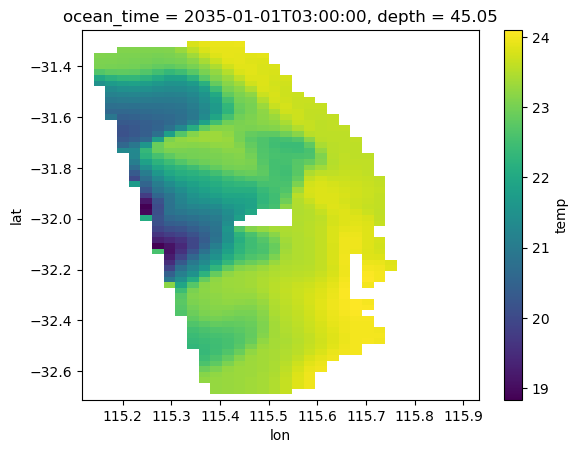

In [10]:
interpolated_ds.temp[1][0].plot()

In [11]:
final_ds = interpolated_ds.rename({'ocean_time': 'time'})
final_ds

<xarray.Dataset>
Dimensions:  (time: 14600, depth: 25, lat: 66, lon: 34)
Coordinates:
  * time     (time) datetime64[ns] 2035-01-01 ... 2039-12-30T21:00:00
  * depth    (depth) float64 45.05 43.19 41.32 39.46 ... 4.045 2.181 0.3176
  * lat      (lat) float64 -32.7 -32.68 -32.66 -32.63 ... -31.31 -31.29 -31.27
  * lon      (lon) float64 115.1 115.2 115.2 115.2 ... 115.8 115.9 115.9 115.9
Data variables:
    temp     (time, depth, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    salt     (time, depth, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0

In [5]:
# Initialize dictionaries to store interpolated data for all variables
interpolated_data = {}

# Loop through the variables in the dataset (e.g., temp, salt)
for var_name in ['temp', 'salt']:
    var_data = ds[var_name].values  # Shape: (ocean_time, s_rho, eta_rho, xi_rho)
    depth_levels = ds.s_rho.size  # Number of depth levels
    
    # Initialize an array to store the interpolated data for the current variable
    interpolated_var = np.empty((var_data.shape[0], depth_levels, len(new_lat), len(new_lon)))
    
    # Loop through each time step and depth level to interpolate
    for t in range(var_data.shape[0]):  # Loop over time
        for d in range(depth_levels):  # Loop over depth
            # Flatten the original lon, lat, and var_data arrays for griddata
            points = np.column_stack([lon.ravel(), lat.ravel()])
            values = var_data[t, d, :, :].ravel()
            
            # Perform the interpolation
            interpolated_var[t, d, :, :] = griddata(points, values, (new_lon_grid, new_lat_grid), method='linear')
    
    # Store the interpolated data in the dictionary
    interpolated_data[var_name] = (['ocean_time', 's_rho', 'lat', 'lon'], interpolated_var)

# Create a new xarray.Dataset with the interpolated data
interpolated_ds = xr.Dataset(
    interpolated_data,
    coords={
        'time': ds['ocean_time'],
        's_rho': ds['s_rho'],
        'lat': new_lat,
        'lon': new_lon
    }
)

# Inspect the new interpolated dataset
print(interpolated_ds)

<xarray.Dataset>
Dimensions:     (ocean_time: 14600, s_rho: 25, lat: 66, lon: 34)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2035-01-01 ... 2039-12-30T21:00:00
  * s_rho       (s_rho) float64 -0.98 -0.94 -0.9 -0.86 ... -0.1 -0.06 -0.02
  * lat         (lat) float64 -32.7 -32.68 -32.66 ... -31.31 -31.29 -31.27
  * lon         (lon) float64 115.1 115.2 115.2 115.2 ... 115.9 115.9 115.9
Data variables:
    temp        (ocean_time, s_rho, lat, lon) float64 nan nan nan ... nan nan
    salt        (ocean_time, s_rho, lat, lon) float64 nan nan nan ... nan nan


In [6]:
interpolated_ds.to_netcdf("/csiem/interpolated_temp_salt_with_Depth_2035.nc")

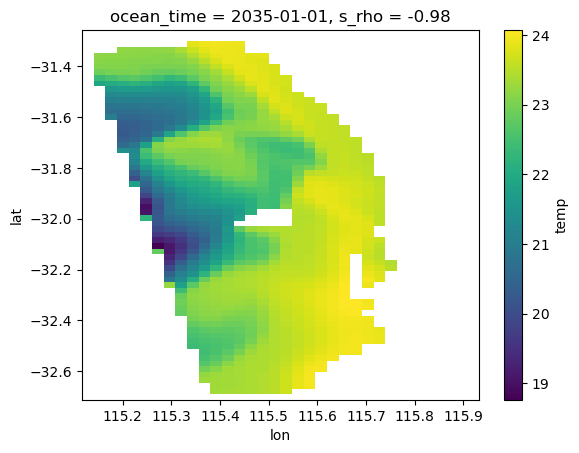

In [9]:
interpolated_ds.temp[0][0].plot()

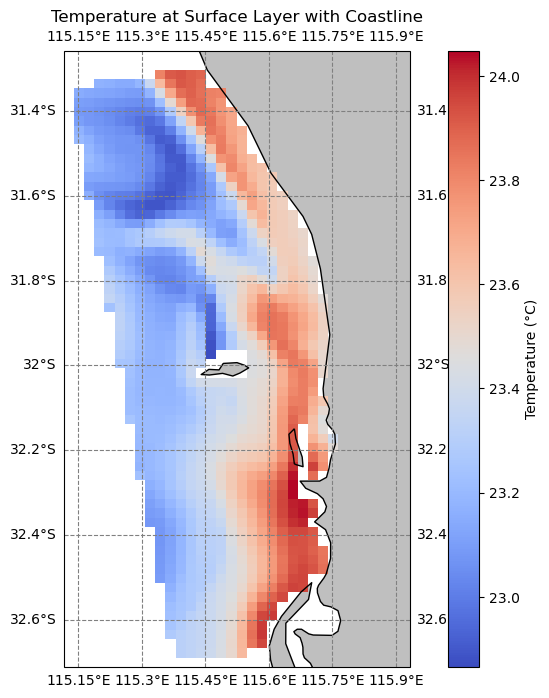

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create the plot
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(10, 8),
)

# Plot the temperature data
interpolated_ds.temp[0, -1].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    cbar_kwargs={"label": "Temperature (°C)"}
)

# Add coastlines
ax.coastlines(resolution="10m", color="black", linewidth=1)

# Add land feature (optional, to mask out land areas)
ax.add_feature(cfeature.LAND, facecolor="gray", alpha=0.5)

# Add gridlines for better spatial reference (optional)
ax.gridlines(draw_labels=True, linestyle="--", color="gray")

# Set title
ax.set_title("Temperature at Surface Layer with Coastline")

plt.show()